In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import whisper

import tiktoken
whisper_tokenizer = whisper.tokenizer.get_tokenizer(tiktoken.get_encoding(tiktoken.list_encoding_names()[-1]), num_languages=1)

import json

with open('config.json') as fileobj:
    hf_token = json.load(fileobj)['hugging_face_token']

import torch

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

import os

from IPython.display import clear_output
clear_output()

import utils
import data_extraction as da
import modelling as md

audio_dir = os.path.join('data', 'audio-vault')
transcription_dir = os.path.join(audio_dir, 'transcriptions')
diarization_dir = os.path.join(audio_dir, 'diarization_segments')

vsd_dir = os.path.join('data', 'VSD', 'VSD2014_officialrelease', 'VSD_2014_December_official_release', 'Hollywood-dev')
vsd_features_dir = os.path.join(vsd_dir, 'features')
vsd_annotations_dir = os.path.join(vsd_dir, 'annotations')

utils.ensure_dir_exists(transcription_dir)

transcript_df_fp = '{movie_name}-transcript.parquet'

max_break = 15 # seconds
max_seg_duration = 60 # seconds

batch_size = 16
num_epochs = 1

# enc_model = 'bert-large-uncased'
enc_model = 'bert-base-uncased'

num_layers = 2
unfreeze_layers = {
    # 'microsoft/deberta-v3-base': 12,
    # 'microsoft/deberta-v3-large': 24,
    'bert-large-uncased': 24,
    'bert-base-uncased': 12,
    'answerdotai/ModernBERT-base': 11,
    'answerdotai/ModernBERT-large': 27
}

whisper_model = 'turbo'
max_enc_len = 1000

excl_dialogue = True

# TODO: utilise bitsandbytes

### TODO:
- Creatures are rarely described in detail but assumed that person views clips of them beforehand?

In [2]:
def calc_speed_ratio(first_annot, last_annot, last_seg):
    return 1 + (last_seg - last_annot) / (last_annot - first_annot)

movie_offsets = {
    # Offset for first event, then multiplier for transcript speed differences
    'PiratesOfTheCarribeanTheCurseOfTheBlackPearl': (95, calc_speed_ratio(1772, 7065, 7291)), # Fantasy
    'SavingPrivateRyan': (14, calc_speed_ratio(663, 8907, 9263)), # War
    'FightClub': (-162, calc_speed_ratio(2542, 7676, 7782)), # Modern
    'IAmLegend': (2, 1), # Dystopian 
    'ReservoirDogs': (-13, calc_speed_ratio(565, 5490, 5465)) # Crime
}

In [3]:
# Extract and tokenize subtitles for matching
subs_dict = da.extract_subs()
subs_df_list = []

for movie, subs_df in subs_dict.items():
    subs_df['dialogue'] = da.clean_dialogue(subs_df['raw_dialogue'])
    subs_df['tokens'] = subs_df['dialogue'].apply(lambda x: whisper_tokenizer.encode(x))
    subs_df['movie'] = movie
    subs_df_list.append(subs_df)
    
subs_df = pd.concat(subs_df_list)

In [4]:
annotations_df = da.get_vsd_movie_annotations(vsd_annotations_dir, list(movie_offsets.keys()))
gore_mask = annotations_df.annotation_cat.eq('gore')
blood_mask = annotations_df.annotation_cat.eq('blood') & annotations_df.desc.isin(['low', 'medium', 'high'])
gore_df = annotations_df[gore_mask | blood_mask].copy()
gore_df['full_annotation_cat'] = gore_df['annotation_cat'] + '-' + gore_df['desc']
gore_df = gore_df.drop(columns=['desc'])

In [5]:
# Convert from 25 fps to seconds, and add ARBITRARY offset based on observation (movies out of sync)
gore_df[['start_sec', 'end_sec']] = gore_df[['start', 'finish']] / 25

gore_df = da.convert_time_to_readable_txt(gore_df, [('start_sec', 'start_txt'), ('end_sec', 'end_txt')])
# Buffering start and finish 1 second either side (no need to be precise)
gore_df['start_sec'] -= 1
gore_df['end_sec'] += 1
gore_df['seg_duration'] = gore_df['end_sec'] - gore_df['start_sec'] 

In [6]:
seg_df = da.get_segments(transcription_dir, gore_df['movie'].unique(), transcript_df_fp, whisper_tokenizer)
seg_df['duration'] = seg_df['end'] - seg_df['start']

gore_df = gore_df.sort_values('start')

# Add individual offsets to align each movie with audio recording
for movie, (offset, ratio) in movie_offsets.items():
    vec = seg_df.loc[seg_df.movie.eq(movie), ['start']]
    first_annot = gore_df['start_sec'][gore_df.movie.eq(movie)].iloc[0]
    seg_df.loc[seg_df.movie.eq(movie), ['start']] = first_annot + (vec - offset - first_annot) / ratio

seg_df['end'] = seg_df['start'] + seg_df['duration']

seg_df = da.convert_time_to_readable_txt(seg_df, [('start', 'start_txt'), ('end', 'end_txt')])

In [7]:
# total_training_steps = (len(train_y) // batch_size) * num_epochs
# quarter_epoch_steps = (total_training_steps // num_epochs) // 4

training_args = TrainingArguments(
    num_train_epochs=num_epochs,
    fp16=True,
    weight_decay=0.01,
    
    eval_strategy='epoch',
    # eval_steps=quarter_epoch_steps,
    logging_strategy="epoch",         
    # logging_steps=quarter_epoch_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    
    output_dir="./results",
    logging_dir="./logs",
    report_to="none",
    
    load_best_model_at_end=True,
    save_strategy='epoch',
    metric_for_best_model="eval_recall",
    greater_is_better=False,
    save_total_limit=1
)

In [ ]:
results = []
movies = seg_df.movie.unique()

for curr_model, last_layer in unfreeze_layers.items():

    logging.info(f'Curr Model: {curr_model}')
        
    tokenizer = AutoTokenizer.from_pretrained(curr_model)
    enc_len = min(max_enc_len, tokenizer.model_max_length) - 5
    agg_seg_df = da.aggregate_segments(seg_df, tokenizer, enc_len, max_seg_duration, max_break, excl_dialogue)
    cat_seg_df = da.annotate_segments(agg_seg_df, gore_df, tokenizer)
    tokens_w_context = da.add_context_and_tokenize(cat_seg_df, tokenizer, enc_len)

    for movie in movies:
        logging.info(f'Current Test Set: {movie}')    
        train_ds, train_y = md.create_test_train_split(cat_seg_df, tokens_w_context, [x for x in movies if x != movie], tokenizer, enc_len)
        test_ds, test_y = md.create_test_train_split(cat_seg_df, tokens_w_context, [movie], tokenizer, enc_len)

        n_pos = train_y.sum()
        pos_weight = torch.tensor([(train_y.shape[0] - n_pos) / n_pos], dtype=torch.float)
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
        thawed_layers = [ii + 1 for ii in range(last_layer - num_layers, last_layer)]
        model = md.CustomLossModel(enc_model, loss_fn, thawed_layers)
        logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_ds,
            eval_dataset=test_ds,
            compute_metrics=md.compute_metrics,
            callbacks=[md.FractionalTrainEvalCallback]
        )

        # torch.cuda.empty_cache()
        trainer.train()
        
        epoch = np.argmax([x for x in trainer.state.log_history if 'eval_recall' in x]) + 1
        
        curr_results = {
            'model': curr_model,
            'test_movie': movie,
            'runtime': trainer.state.log_history[-1]['train_runtime'],
            'epoch': epoch,
            'recall': next(x for x in trainer.state.log_history if 'epoch' in x and x['epoch'] == epoch and 'eval_recall' in x),
            'f1_macro': next(x for x in trainer.state.log_history if 'epoch' in x and x['epoch'] == epoch and 'eval_f1_macro' in x),
        }
        results.append(curr_results)

INFO - 2025-05-22 14:45:42,885 - Curr Model: answerdotai/ModernBERT-base
INFO - 2025-05-22 14:45:45,173 - Current Test Set: PiratesOfTheCarribeanTheCurseOfTheBlackPearl


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Per Model
# Per Movie
# Pred Accuracy, TPR
# Training Time
# Epoch selected


In [ ]:
train_preds = trainer.predict(train_ds)
test_preds = trainer.predict(test_ds)

In [ ]:
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"[FROZEN] {name}")
    else:
        print(f"[TRAINABLE] {name}")

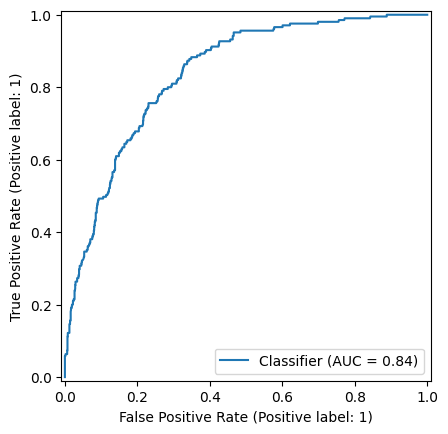

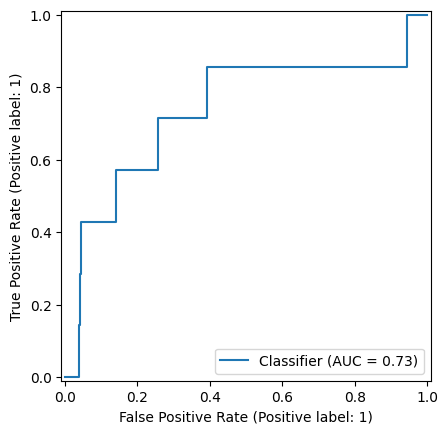

In [ ]:
RocCurveDisplay.from_predictions(train_y, train_preds.predictions)
RocCurveDisplay.from_predictions(test_y, test_preds.predictions)